In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time

from imageio import imread
from skimage.transform import resize
from scipy.ndimage.filters import convolve
from numpy.linalg import svd, matrix_rank

(256, 256)


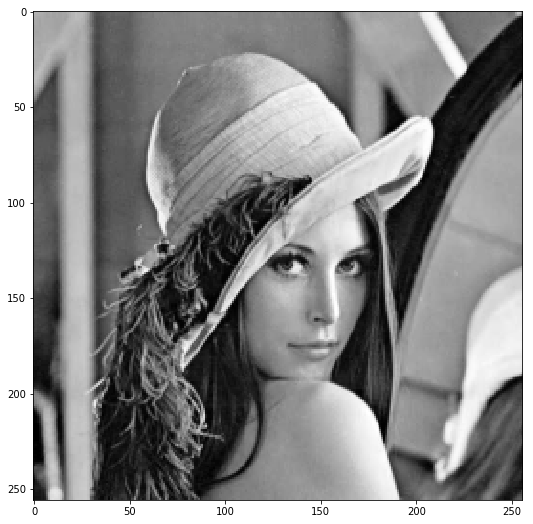

In [32]:
im = imread("../../samples/lena.jpg", pilmode="L")
im = resize(im, (256,256), mode="reflect", anti_aliasing=True)
im = (im * 255).astype(np.uint8)

print(im.shape)

fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(im, cmap=plt.cm.gray)
plt.show()

def gauss_filter(size=5, sigma=1):
    """
    creates gaussian kernel with a given size and sigma
    """
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    return kernel / kernel.sum()

# Exersice 2: Spatial Filtering (Convolution)

**Filtering** is a discrete convolution of an image $I$ with a filter mask $A \in \mathbb{R}^{m \times n}$:

$$
\begin{align}
 I_{A}       &= I * A \\
 I_{A}(i, j) &= \left(I * A\right)(i, j) \\
                                       &= \sum_{h=-\frac{m}{2}}^{\frac{m}{2}} \sum_{k=-\frac{n}{2}}^{\frac{n}{2}} A\left(h + \frac{m}{2} , k+\frac{n}{2}\right) \cdot I(i-h, j-k)
\end{align}
$$

Typically, the filter masks are square matrices, meaning $n=m$.
A special filter mask can be a **box filter**:

$$
\begin{align}
  B =%
  \dfrac{1}{9}\begin{pmatrix}
              1&1&1\\1&1&1\\1&1&1
             \end{pmatrix}.
\end{align}
$$

## Task 3 - Separable Filters
A 2D convolution filter $C \in \mathbb{R}^{m \times n}$ is called **separable**, if it is possible to decompose it into two 1D convolution filters $D_1 \in \mathbb{R}^{m}$ and $D_2 \in \mathbb{R}^{n}$ such that

$$
\begin{align}
  \forall I \in \mathbb{R}^{k \times l}: \quad I * C = (I * D_1) * D_2
\end{align}
$$

As the convolution is associative, this can be expressed in closed form 
$$
C = D_1 * D_2
$$

and since $D_1$ and $D_2$ are column and row vectors, the condition is equivalent to 

$$
C = D_1 D_2^\top
$$

- Given a matrix $C$, how can we compute suitable vectors $D_1$ and $D_2$? How can you decide if a matrix $C$ is separable?
- Compare the runtime of <code>scipy.ndimage.filters.convolve</code> for separable and non-separable filters of different sizes. Visualize the runtimes in a plot!
- **Challenge yourself**: modify your function from task 1 so that it checks if the given 2D filter is separable and if it is the case, than it should separate the filter and perform two 1D convolutions. Compare now the runtime of your new function for separable and non-separable filters.

### Solutions

In [33]:
def check_filter(mask):
    """ 
        returns True if mask is decomposable and
        False otherwise
    """
    return matrix_rank(mask) == 1

def decompose(mask):
    """
        decomposes mask in two vectors
    """
    U, S, V = svd(mask)
    """
    Singular Value Decomposition
    https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html
    """

    D1 = U.dot(np.sqrt(S)).reshape(-1,1)
    D2 = np.sqrt(S).dot(V).reshape(1,-1)
    
    return D1, D2


In [34]:
size = 3
B = np.ones((size, size), dtype=np.float32) / size**2


print("=" * 30)
print("Filter: \n", B)
print("Is decomposable:", check_filter(B))
B1, B2 = decompose(B)
print("Decomposed Vectors", B1, B2, sep="\n")
print("Estimated Filter:\n", B1 @ B2)

# create a separable filter mask ("Gaussian")
H = gauss_filter(size)

print("=" * 30)
print("Filter: \n", H)
print("Is decomposable:", check_filter(H))
H1, H2 = decompose(H)
print("Decomposed Vectors", H1, H2, sep="\n")
print("Estimated Filter:\n", H1 @ H2)



Filter: 
 [[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]
Is decomposable: True
Decomposed Vectors
[[-0.3333333]
 [-0.3333333]
 [-0.3333333]]
[[-0.3333333 -0.3333333 -0.3333333]]
Estimated Filter:
 [[0.1111111 0.1111111 0.1111111]
 [0.1111111 0.1111111 0.1111111]
 [0.1111111 0.1111111 0.1111111]]
Filter: 
 [[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]
Is decomposable: True
Decomposed Vectors
[[-0.27406861]
 [-0.45186276]
 [-0.27406862]]
[[-0.27406862 -0.45186276 -0.27406862]]
Estimated Filter:
 [[0.07511361 0.1238414  0.07511361]
 [0.12384141 0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]


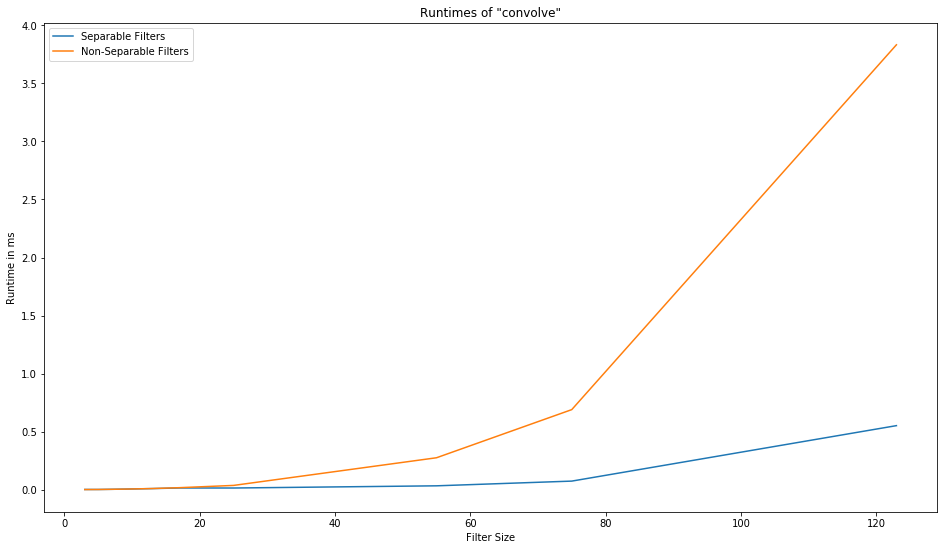

In [38]:
def plot_runtimes(im, sizes, conv_func):
    xs = sizes
    ys_sep = []
    ys_nonsep = []
    
    for size in sizes:
        sep_filter = gauss_filter(size)
        non_sep_filter = np.random.randn(size, size)
        
        t0 = time.time()
        _res = conv_func(im, sep_filter)
        t1 = time.time()
        ys_sep.append(t1 - t0)
        
        t0 = time.time()
        _res = conv_func(im, non_sep_filter)
        t1 = time.time()
        ys_nonsep.append(t1 - t0)
        
    
    fig, ax = plt.subplots(figsize=(16,9))
    
    ax.set_title("Runtimes of \"{}\"".format(conv_func.__name__))
    ax.set_xlabel("Filter Size")
    ax.set_ylabel("Runtime in ms")
    ax.plot(xs, ys_sep, label="Separable Filters")
    ax.plot(xs, ys_nonsep, label="Non-Separable Filters")
    
    ax.legend()
    
    plt.show()
    plt.close()

    
sizes = [3,5,7,9,13,17,25,55,75,123]
plot_runtimes(im, sizes, convolve)

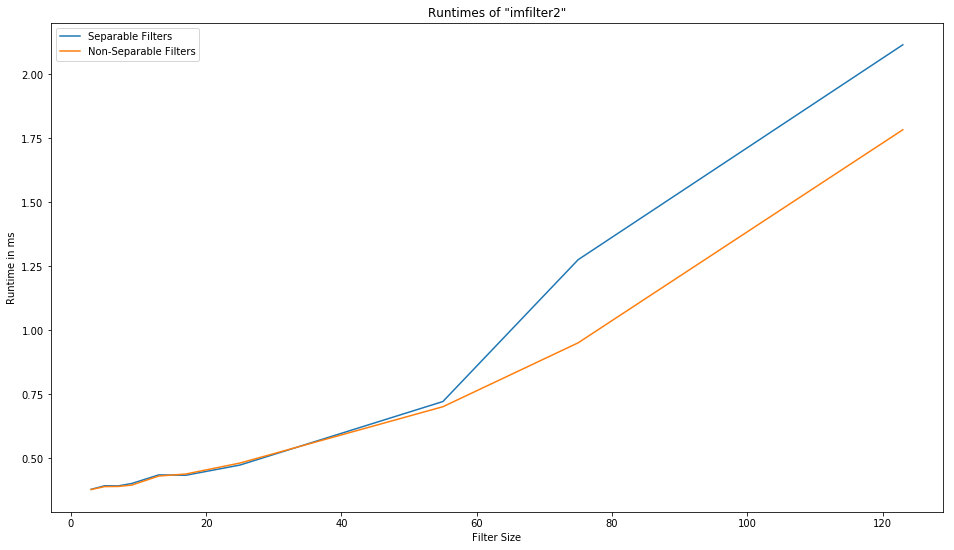

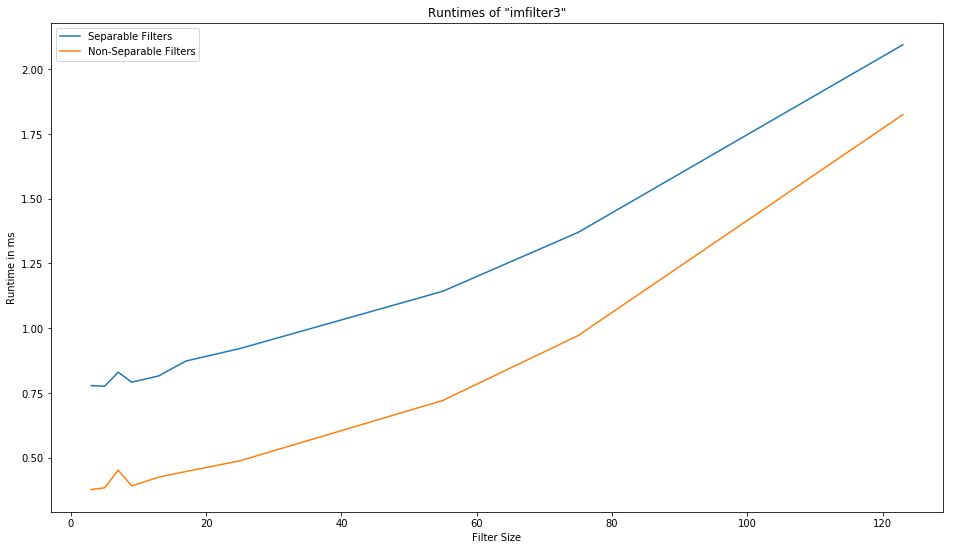

In [37]:
def imfilter2(im, mask, mode="edge"):
    
    h, w = im.shape
    m, n = mask.shape
    
    m_delta, n_delta = int((m-1) / 2), int((n-1) / 2)
    result = np.zeros(im.shape, dtype=np.float32)
    
    # extend (pad) the image
    im_padded = np.pad(im, [(m_delta, m_delta), (n_delta, n_delta)], mode=mode)
    new_h, new_w = im_padded.shape
    
    for y in np.arange(h) + m_delta:
        for x in np.arange(w) + n_delta:
            
            # compute the extents of our current image are
            x0, x1 = x - n_delta, x + n_delta + 1
            y0, y1 = y - n_delta, y + n_delta + 1
            
            # compute the output coordinates
            x_out = x - n_delta
            y_out = y - m_delta
            
            # get the image patch and weight it with the mask values
            im_patch = im_padded[y0:y1, x0:x1] * mask
            
            # store the sum of weighted pixel in the result image
            result[y_out, x_out] = im_patch.sum()
    return result.astype(im.dtype)

def imfilter3(im, mask):
    if check_filter(mask):
        m1, m2 = decompose(mask)
        return imfilter2(imfilter2(im, m1), m2)
    else:
        return imfilter2(im, mask)
    

sizes = [3,5,7,9,13,17,25,55,75,123]
plot_runtimes(im, sizes, imfilter2)
plot_runtimes(im, sizes, imfilter3)